# Macroeconomic Predictor

This notebook will explore the effects of macroecnonomic factors on the stock market. For my analysis, I intend to specifically focus on the impacts on the S&P 500 index as that broadly generalizes the economic state of the top United States companies.

In [33]:
from alpaca.data import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
from datetime import datetime

from fredapi import Fred
import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Task 1: Find S&P 500 Data

Given my initial research, I believe that Alpaca's python API should be able to give us all of the historical S&P 500 data we will need for this task. I requested the API key from Alpaca's website. For the sake of keeping all of my keys safe, I will import them from my local environment variables and use them for the execution of the notebook. 

### Alpaca

In [34]:
alpaca_api_key = os.getenv('ALPACA_API_KEY')
alpaca_secret_key = os.getenv('ALPACA_SECRET_KEY')

client = StockHistoricalDataClient(alpaca_api_key, alpaca_secret_key)

request_params = StockBarsRequest(
                        symbol_or_symbols="SPY",
                        timeframe=TimeFrame(1, TimeFrameUnit.Month),
                        start=datetime(2000, 1, 1),
                        end=datetime(2025, 3, 31)
                 )

bars = client.get_stock_bars(request_params)

bars_df = bars.df
bars_df

ValueError: You must supply a method of authentication

Unfortunately, I can tell that Alpaca is not the right dataset to use to get S&P 500 data as it does not go all the way back to the index's inception. Instead, I will try using **fredapi**'s built in S&P 500 tracker to see if that goes all the way to the index's origins.

### FredAPI

Before starting with **fredapi**, I first had to get a key from them. This was done by applying from their website.

In [6]:
fred_key = os.getenv('FRED_KEY')
fred = Fred(api_key=fred_key)

In [4]:
# Get S&P 500 index data (daily closes)
sp500_fred = fred.get_series('SP500')

# Convert to DataFrame
# TODO: Show the original DF and then try and limit it to closes
sp500_fred = sp500_fred.to_frame(name='SP500_Close')
sp500_fred.index = pd.to_datetime(sp500_fred.index)
sp500_fred

,SP500_Close
2015-08-03,2098.04
2015-08-04,2093.32
2015-08-05,2099.84
2015-08-06,2083.56
2015-08-07,2077.57
...,...
2025-07-25,6388.64
2025-07-28,6389.77
2025-07-29,6370.86
2025-07-30,6362.90


FRED is also not the right source as it doesn't go all the way back to the inception of the S&P 500. I have also found that **yfinance** might have the capabilities/data to support the predictive task.

### yfinance

In [39]:
# S&P 500 Index (not an ETF)
sp500_yf = yf.download("^GSPC", start="1950-01-01", interval="1d", auto_adjust=True)
sp500_yf

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
1950-01-03,16.660000,16.660000,16.660000,16.660000,1260000
1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000
1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000
1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000
1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000
...,...,...,...,...,...
2025-07-30,6362.899902,6396.540039,6336.379883,6381.229980,5375070000
2025-07-31,6339.390137,6427.020020,6327.640137,6427.020020,6077080000


Given that the "**yfinance**" library does have a ticker that has data all the way back since the S&P 500's inception, I will use this dataset to merge into our macroeconomic factors DataFrame.

In [40]:
# Keep only the close price
sp500 = sp500_yf[['Close']]
sp500 = sp500.rename(columns={'Close': 'SP500_Close'})
sp500 = sp500.resample('MS').last()
sp500

Price,SP500_Close
Ticker,^GSPC
Date,
1950-01-01,17.049999
1950-02-01,17.219999
1950-03-01,17.290001
1950-04-01,17.959999
1950-05-01,18.780001
...,...
2025-04-01,5569.060059
2025-05-01,5911.689941


In [41]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 908 entries, 1950-01-01 to 2025-08-01
Freq: MS
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   (SP500_Close, ^GSPC)  908 non-null    float64
dtypes: float64(1)
memory usage: 14.2 KB


In [42]:
sp500.describe().T

,,count,mean,std,min,25%,50%,75%,max
Price,Ticker,,,,,,,,
SP500_Close,^GSPC,908.0,893.207245,1262.9825,17.049999,89.245001,271.964996,1260.075012,6339.390137


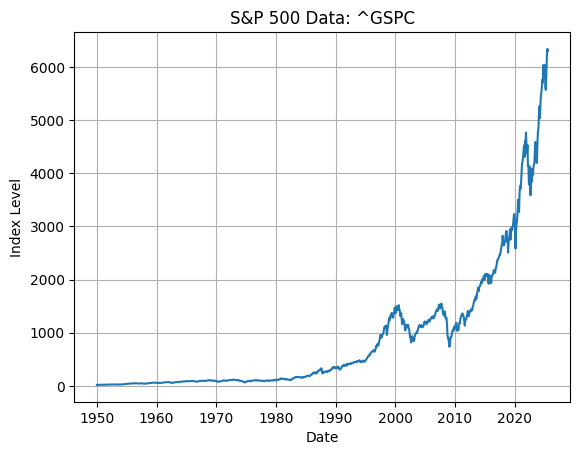

In [43]:
plt.plot(sp500)
plt.title('S&P 500 Data: ^GSPC')
plt.xlabel('Date')
plt.ylabel('Index Level')
plt.grid(True)

**NOTE**: I will also make my target variable to be percent change from the current S&P 500 value. This is because I still want to assume some sort of stationarity with our data, and I want to make my models more statistically sound. Because the graph of the S&P 500 value has exponentially increased over time, I would think that predicting the percent change will yield more stable mean, median, and variance values.

I will also shift the percent changes between the current month and the previous month up by one row. This is because my goal for this task is to have my current month's macroeconomic data successfully predict the percent change to next month's stock values. The shift will accomplish that idea.

In [44]:
sp500['SP500_Shifted_Pct'] = sp500['SP500_Close'].pct_change().shift(-1)
sp500 = sp500.drop(columns=['SP500_Close'])
sp500.tail()

Price,SP500_Shifted_Pct
Ticker,
Date,
2025-04-01,0.061524
2025-05-01,0.049607
2025-06-01,0.021667
2025-07-01,-0.006341
2025-08-01,NaN


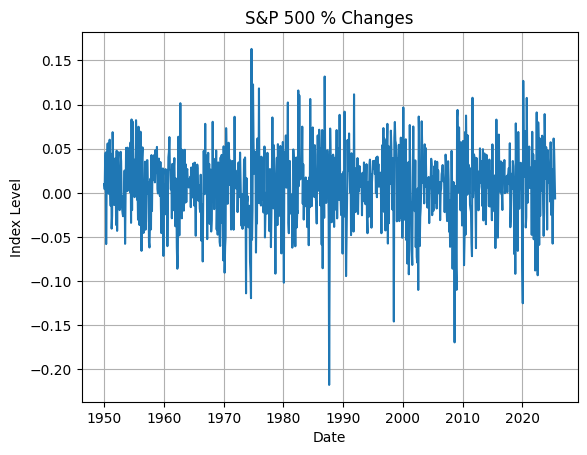

In [45]:
plt.plot(sp500)
plt.title('S&P 500 % Changes') 
plt.xlabel('Date')
plt.ylabel('Index Level')
plt.grid(True)

## Task 2: Find Macroeconomic Data

Now that our S&P 500 data has been secured as our response variable, I will now find all of the macroeconomic features that I want to compare against each other in order to fulfill the research question I originally posed. Not only do I want to quantify the effects of macroeconomic factors on the stock market, but I want to evaluate which of these features has the most impact, either positive or negative. To meet that goal, I have read through the **fredapi** documentation and other articles on impactful macroeconomic factors to find the features that I think best represent the areas that highlight important macroeconomic factors. The list is as follows:

CPI: Consumer Price Index

UNRATE: Unemployment Rate

FEDFUNDS: Federal Funds Rate

GS10: 10 Year Treasury Rate

M2: Money Supply - how much money is in circulation

INDPRO: Industrial Production Index

RSAFS: Retail and Food Service Sales

UMCSENT: University of Michigan Consumer Sentiment Index

HOUST: Housing Starts

MSPUS: Median House Price

TWEXB: US Dollar Strength

NETEXP: Net Exports

In [46]:
start_date="1947-01-01"
macro_factors = {
    'CPI': 'CPIAUCSL',
    'UNRATE': 'UNRATE',
    'FEDFUNDS': 'FEDFUNDS',
    'GS10': 'GS10',
    'M2': 'M2SL',
    'INDPRO': 'INDPRO',
    'RSAFS': 'RSAFS',
    'UMCSENT': 'UMCSENT',
    'HOUST': 'HOUST',
    'MSPUS': 'MSPUS',
    'TWEXB': 'TWEXB',
    'NETEXP': 'NETEXP'
}

fred_df = pd.DataFrame()

# Add each of the macroeconomic features to the dataframe
for key, value in macro_factors.items():
    data = fred.get_series(value)
    fred_df[key] = data

# Resample to get end of month values
fred_df = fred_df.resample('ME').last().ffill()

fred_df

,CPI,UNRATE,FEDFUNDS,GS10,M2,INDPRO,RSAFS,UMCSENT,HOUST,MSPUS,TWEXB,NETEXP
1947-01-31,21.480,NaN,NaN,NaN,NaN,13.6554,NaN,NaN,NaN,NaN,NaN,10.875
1947-02-28,21.620,NaN,NaN,NaN,NaN,13.7361,NaN,NaN,NaN,NaN,NaN,10.875
1947-03-31,22.000,NaN,NaN,NaN,NaN,13.8167,NaN,NaN,NaN,NaN,NaN,10.875
1947-04-30,22.000,NaN,NaN,NaN,NaN,13.7092,NaN,NaN,NaN,NaN,NaN,11.294
1947-05-31,21.950,NaN,NaN,NaN,NaN,13.7629,NaN,NaN,NaN,NaN,NaN,11.294
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28,319.775,4.1,4.33,4.45,21584.1,103.9397,711757.0,64.7,1490.0,423100.0,128.6539,-1245.141
2025-03-31,319.615,4.2,4.33,4.28,21656.9,103.6682,722572.0,57.0,1355.0,423100.0,128.6539,-1245.141
2025-04-30,320.321,4.2,4.33,4.28,21804.5,103.6912,721789.0,52.2,1398.0,410800.0,128.6539,-872.384
2025-05-31,320.580,4.2,4.33,4.42,21883.6,103.6602,715541.0,52.2,1263.0,410800.0,128.6539,-872.384


In [47]:
fred_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 942 entries, 1947-01-31 to 2025-06-30
Freq: ME
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   CPI       942 non-null    float64
 1   UNRATE    930 non-null    float64
 2   FEDFUNDS  852 non-null    float64
 3   GS10      867 non-null    float64
 4   M2        798 non-null    float64
 5   INDPRO    942 non-null    float64
 6   RSAFS     402 non-null    float64
 7   UMCSENT   872 non-null    float64
 8   HOUST     798 non-null    float64
 9   MSPUS     750 non-null    float64
 10  TWEXB     365 non-null    float64
 11  NETEXP    942 non-null    float64
dtypes: float64(12)
memory usage: 95.7 KB


### Analyze Missing Values

TWEXB       577
RSAFS       540
MSPUS       192
M2          144
HOUST       144
FEDFUNDS     90
GS10         75
UMCSENT      70
UNRATE       12
CPI           0
INDPRO        0
NETEXP        0
dtype: int64


Text(0.5, 1.0, 'Missing Macroeconomic Data by Feature')

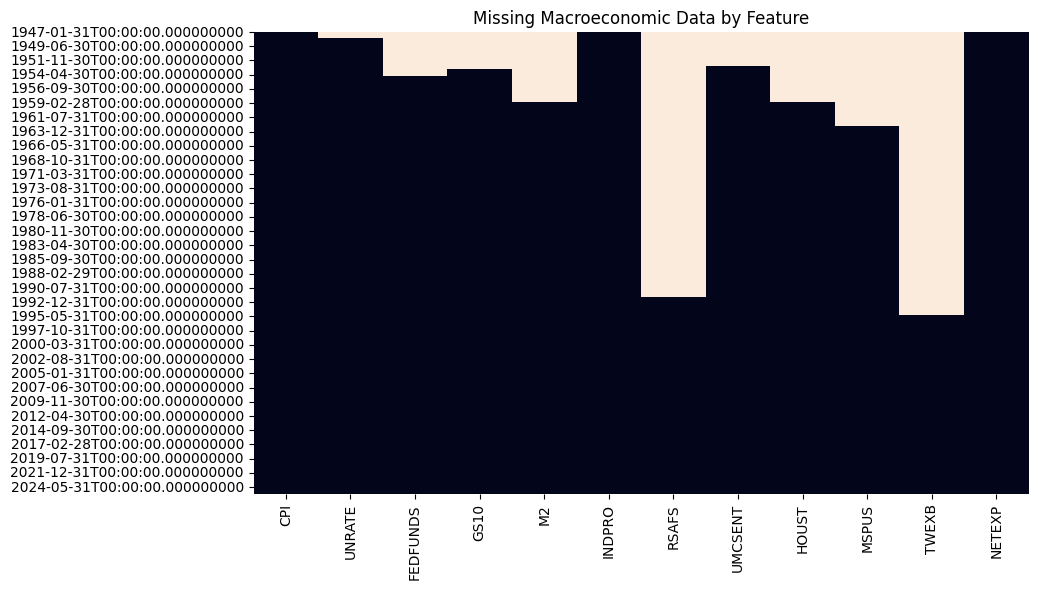

In [48]:
# Count missing values
missing = fred_df.isnull().sum().sort_values(ascending=False)
print(missing)

# Visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(fred_df.isnull(), cbar=False)
plt.title("Missing Macroeconomic Data by Feature")

After analyzing our initial dataframe, I can see that the features with the most missing values are "RSAFS: Retail and Food Service Sales" and "TWEXB: US Dollar Strength". Because these features have such limited amounts of data, I would rather choose to drop them from our dataframe entirely such that we can retain as much of the data as possible. Despite how much I believe they can contribute meaningful value to the analysis of macroeconomic impacts on the stock market, I would rather drop them for the sake of not having to impute the data with proper values. For the rest of the missing data, most of these features are missing data at the beginning of their series. As a result, I plan to drop all null/NA values until I get the data to a point where all of the features have a value that I can forward fill if necessary.

In [49]:
fred_df.drop(columns=['TWEXB', 'RSAFS'], inplace=True)
fred_df.dropna(inplace=True)
fred_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 750 entries, 1963-01-31 to 2025-06-30
Freq: ME
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   CPI       750 non-null    float64
 1   UNRATE    750 non-null    float64
 2   FEDFUNDS  750 non-null    float64
 3   GS10      750 non-null    float64
 4   M2        750 non-null    float64
 5   INDPRO    750 non-null    float64
 6   UMCSENT   750 non-null    float64
 7   HOUST     750 non-null    float64
 8   MSPUS     750 non-null    float64
 9   NETEXP    750 non-null    float64
dtypes: float64(10)
memory usage: 64.5 KB


In [50]:
fred_df.describe().T

,count,mean,std,min,25%,50%,75%,max
CPI,750.0,147.333312,82.591165,30.440,66.0500,147.15000,217.33275,321.5000
UNRATE,750.0,5.871600,1.731922,3.400,4.6000,5.60000,7.00000,14.8000
FEDFUNDS,750.0,4.899920,3.680550,0.050,1.9100,4.85500,6.58000,19.1000
GS10,750.0,5.866573,2.962599,0.620,3.8725,5.61000,7.58000,15.3200
M2,750.0,5888.623733,5949.748390,365.200,1336.3750,3479.80000,8485.57500,22020.8000
INDPRO,750.0,70.788901,25.257246,25.913,48.3068,67.67055,96.92460,104.1038
UMCSENT,750.0,85.042133,13.015177,50.000,75.4000,88.55000,94.70000,112.0000
HOUST,750.0,1434.421333,388.287736,478.000,1198.5000,1460.00000,1656.00000,2494.0000
MSPUS,750.0,158201.200000,117653.169938,17800.000,56100.0000,129850.00000,236400.00000,442600.0000
NETEXP,750.0,-282.616672,306.705374,-1245.141,-530.7510,-109.16550,-14.75000,21.5820


**NOTE**: Because the problem I am trying to solve involves trying to predict future stock market movement/trends based on current macroeconomic data, I have read that it is wise to lag the data provided by 'fred_df' since that will simulate us predicting into the future. As an arbitrary starting point, I will add 3 different months of lag. TODO: Add lags

## Task 3: Visualize the Features

Now that we have our feature dataframe all tidy, I will now graph the features to see if we can extract any preliminary analysis about the data. Below, I will start by showing the trends of each feature over time.

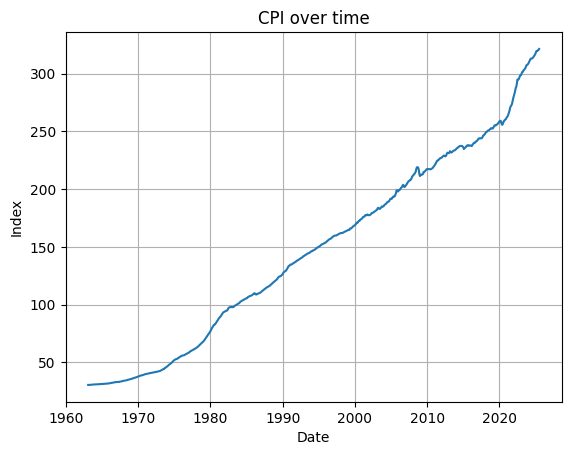

In [16]:
# Examine CPI trends
sns.lineplot(fred_df['CPI'])
plt.title('CPI over time')
plt.xlabel('Date')
plt.ylabel('Index')
plt.grid(True)

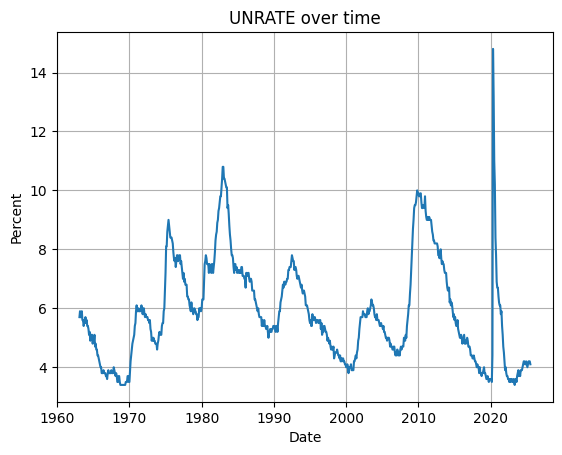

In [17]:
# Examine unemployment rate trends
sns.lineplot(fred_df['UNRATE'])
plt.title('UNRATE over time')
plt.xlabel('Date')
plt.ylabel('Percent')
plt.grid(True)

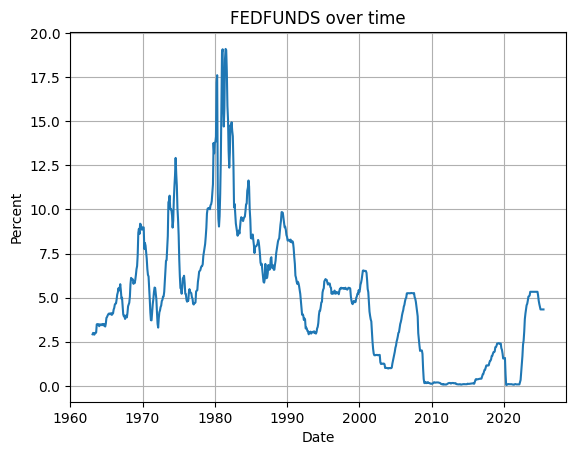

In [18]:
# Examine federal funds rate trends
sns.lineplot(fred_df['FEDFUNDS'])
plt.title('FEDFUNDS over time')
plt.xlabel('Date')
plt.ylabel('Percent')
plt.grid(True)

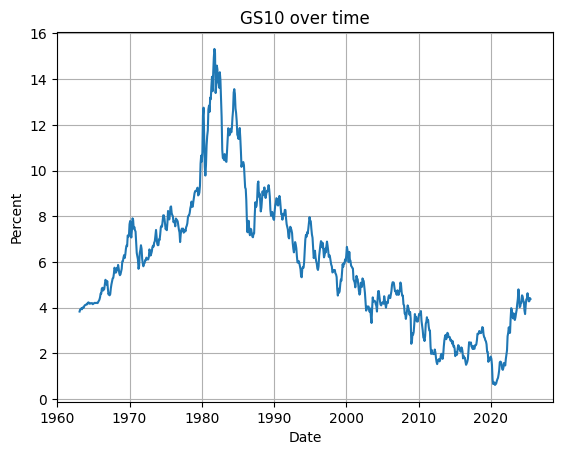

In [19]:
# Examine GS10 trends
sns.lineplot(fred_df['GS10'])
plt.title('GS10 over time')
plt.xlabel('Date')
plt.ylabel('Percent')
plt.grid(True)

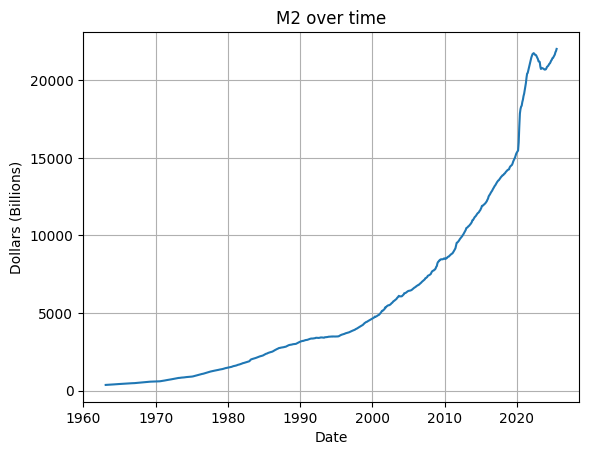

In [20]:
# Examine M2 trends
sns.lineplot(fred_df['M2'])
plt.title('M2 over time')
plt.xlabel('Date')
plt.ylabel('Dollars (Billions)')
plt.grid(True)

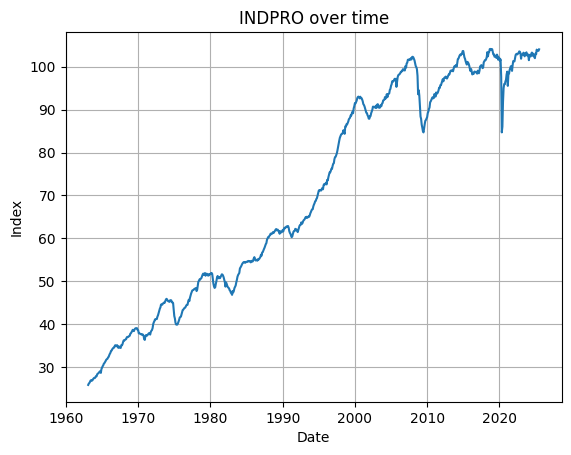

In [21]:
# Examine INDPRO trends
sns.lineplot(fred_df['INDPRO'])
plt.title('INDPRO over time')
plt.xlabel('Date')
plt.ylabel('Index')
plt.grid(True)

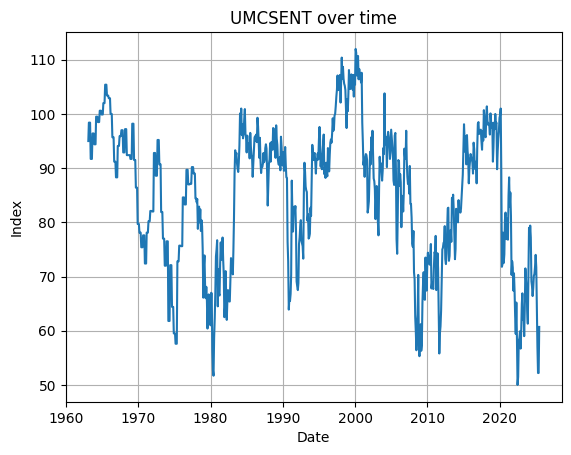

In [22]:
# Examine consumer sentiment trends
sns.lineplot(fred_df['UMCSENT'])
plt.title('UMCSENT over time')
plt.xlabel('Date')
plt.ylabel('Index')
plt.grid(True)

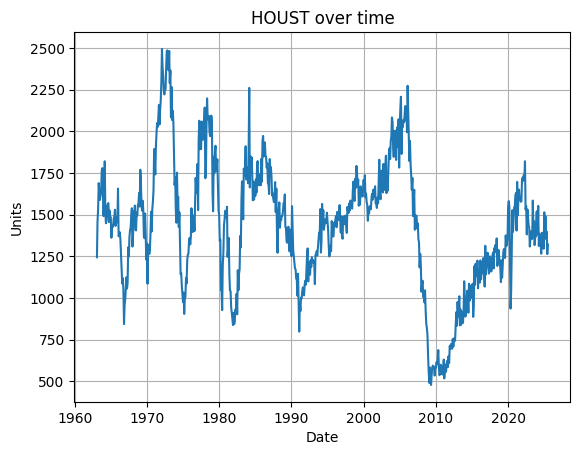

In [23]:
# Examine HOUST trends
sns.lineplot(fred_df['HOUST'])
plt.title('HOUST over time')
plt.xlabel('Date')
plt.ylabel('Units')
plt.grid(True)

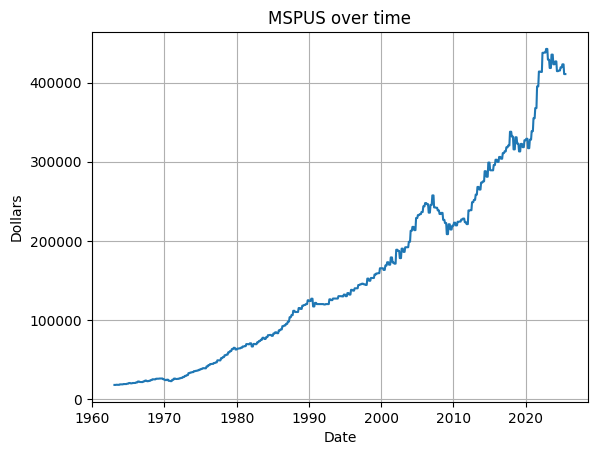

In [24]:
# Examine MSPUS trends
sns.lineplot(fred_df['MSPUS'])
plt.title('MSPUS over time')
plt.xlabel('Date')
plt.ylabel('Dollars')
plt.grid(True)

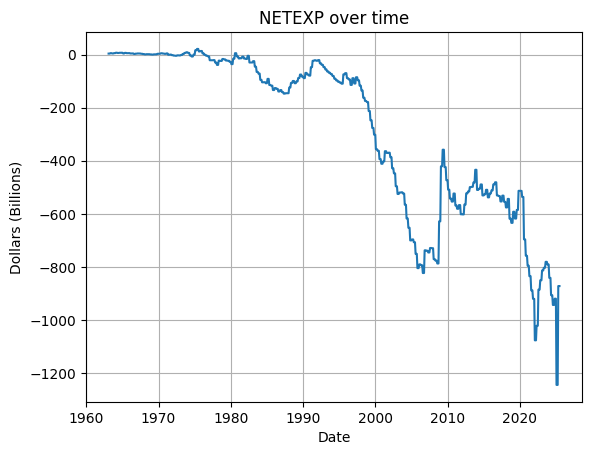

In [25]:
# Examine NETEXP trends
sns.lineplot(fred_df['NETEXP'])
plt.title('NETEXP over time')
plt.xlabel('Date')
plt.ylabel('Dollars (Billions)')
plt.grid(True)

Based on the plots of the features, the only outlier in the graphs would be when the unemployment rate spiked right around 2020. This is best explained by the COVID-19 pandemic, and I will keep an eye on it to make sure that this irregularity in what was going on in the world doesn't skew the bias of this feature too much. However, if we compare this to our S&P 500 data, we also see that the stock market was impacted by COVID-19, meaning that maybe there is some sort of inverse relationship between unemployment rates and the stock market value. It could still be the case that since unemployment rates grew because of COVID, this is what adversely affected the markets.

## Task 4: Outlier Check

In [26]:
Q1 = fred_df.quantile(0.25)
Q3 = fred_df.quantile(0.75)
IQR = Q3 - Q1

# Find outliers the IQR formula
outliers = ((fred_df < (Q1 - 1.5 * IQR)) | (fred_df > (Q3 + 1.5 * IQR)))

# Count number of outliers per feature
outlier_counts = outliers.sum()

print(outlier_counts)

CPI          0
UNRATE       5
FEDFUNDS    23
GS10        20
M2          54
INDPRO       0
UMCSENT      0
HOUST       12
MSPUS        0
NETEXP       0
dtype: int64


## Task 5: Join the Datasets

In [27]:
# Ensure both indices are datetime and have same alignment
sp500.index = pd.to_datetime(sp500.index).to_period('M').to_timestamp(how='end')
fred_df.index = pd.to_datetime(fred_df.index).to_period('M').to_timestamp(how='end')

# Flatten the index from multi-level index to single index
sp500.columns = sp500.columns.get_level_values(0)

# Join the two dataframes
combined_df = fred_df.join(sp500, how='inner')

print(combined_df.info())
combined_df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 750 entries, 1963-01-31 23:59:59.999999999 to 2025-06-30 23:59:59.999999999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CPI                750 non-null    float64
 1   UNRATE             750 non-null    float64
 2   FEDFUNDS           750 non-null    float64
 3   GS10               750 non-null    float64
 4   M2                 750 non-null    float64
 5   INDPRO             750 non-null    float64
 6   UMCSENT            750 non-null    float64
 7   HOUST              750 non-null    float64
 8   MSPUS              750 non-null    float64
 9   NETEXP             750 non-null    float64
 10  SP500_Shifted_Pct  750 non-null    float64
dtypes: float64(11)
memory usage: 70.3 KB
None


,CPI,UNRATE,FEDFUNDS,GS10,M2,INDPRO,UMCSENT,HOUST,MSPUS,NETEXP,SP500_Shifted_Pct
1963-01-31 23:59:59.999999999,30.440,5.7,2.92,3.83,365.2,25.9130,95.0,1244.0,17800.0,3.976,-0.028852
1963-02-28 23:59:59.999999999,30.480,5.9,3.00,3.92,367.9,26.2088,98.4,1456.0,17800.0,3.976,0.035464
1963-03-31 23:59:59.999999999,30.510,5.7,2.98,3.93,370.7,26.3700,98.4,1534.0,17800.0,3.976,0.048520
1963-04-30 23:59:59.999999999,30.480,5.7,2.90,3.97,373.3,26.6120,98.4,1689.0,18000.0,5.558,0.014327
1963-05-31 23:59:59.999999999,30.510,5.9,3.00,3.93,376.1,26.9345,91.7,1641.0,18000.0,5.558,-0.020198
...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28 23:59:59.999999999,319.775,4.1,4.33,4.45,21584.1,103.9397,64.7,1490.0,423100.0,-1245.141,-0.057545
2025-03-31 23:59:59.999999999,319.615,4.2,4.33,4.28,21656.9,103.6682,57.0,1355.0,423100.0,-1245.141,-0.007625
2025-04-30 23:59:59.999999999,320.321,4.2,4.33,4.28,21804.5,103.6912,52.2,1398.0,410800.0,-872.384,0.061524
2025-05-31 23:59:59.999999999,320.580,4.2,4.33,4.42,21883.6,103.6602,52.2,1263.0,410800.0,-872.384,0.049607


In [28]:
#TODO: Add lags + add section explaining lags

## Task 4: Clean the Data

In [29]:
combined_df.dropna(inplace=True)
print(combined_df.info())
combined_df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 750 entries, 1963-01-31 23:59:59.999999999 to 2025-06-30 23:59:59.999999999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CPI                750 non-null    float64
 1   UNRATE             750 non-null    float64
 2   FEDFUNDS           750 non-null    float64
 3   GS10               750 non-null    float64
 4   M2                 750 non-null    float64
 5   INDPRO             750 non-null    float64
 6   UMCSENT            750 non-null    float64
 7   HOUST              750 non-null    float64
 8   MSPUS              750 non-null    float64
 9   NETEXP             750 non-null    float64
 10  SP500_Shifted_Pct  750 non-null    float64
dtypes: float64(11)
memory usage: 70.3 KB
None


,CPI,UNRATE,FEDFUNDS,GS10,M2,INDPRO,UMCSENT,HOUST,MSPUS,NETEXP,SP500_Shifted_Pct
1963-01-31 23:59:59.999999999,30.44,5.7,2.92,3.83,365.2,25.9130,95.0,1244.0,17800.0,3.976,-0.028852
1963-02-28 23:59:59.999999999,30.48,5.9,3.00,3.92,367.9,26.2088,98.4,1456.0,17800.0,3.976,0.035464
1963-03-31 23:59:59.999999999,30.51,5.7,2.98,3.93,370.7,26.3700,98.4,1534.0,17800.0,3.976,0.048520
1963-04-30 23:59:59.999999999,30.48,5.7,2.90,3.97,373.3,26.6120,98.4,1689.0,18000.0,5.558,0.014327
1963-05-31 23:59:59.999999999,30.51,5.9,3.00,3.93,376.1,26.9345,91.7,1641.0,18000.0,5.558,-0.020198


There should be no duplicates (because this is a time series), but just in case there was something wrong with the sampling or the API, I will attempt to drop any duplicates.

In [30]:
combined_df.drop_duplicates(inplace=True)
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 750 entries, 1963-01-31 23:59:59.999999999 to 2025-06-30 23:59:59.999999999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CPI                750 non-null    float64
 1   UNRATE             750 non-null    float64
 2   FEDFUNDS           750 non-null    float64
 3   GS10               750 non-null    float64
 4   M2                 750 non-null    float64
 5   INDPRO             750 non-null    float64
 6   UMCSENT            750 non-null    float64
 7   HOUST              750 non-null    float64
 8   MSPUS              750 non-null    float64
 9   NETEXP             750 non-null    float64
 10  SP500_Shifted_Pct  750 non-null    float64
dtypes: float64(11)
memory usage: 70.3 KB


Based on the results, we did not drop any duplicates as the row count stayed the same.

## Task 5: Modeling

In [32]:
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Users/nathannakamura/Library/Python/3.9/lib/python/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <89AD948E-E564-3266-867D-7AF89D6488F0> /Users/nathannakamura/Library/Python/3.9/lib/python/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file)"]
